In [1]:
# ! pip install --upgrade pip
# ! pip install --user numpy scipy matplotlib seaborn boost_histogram pandas uproot awkward-pandas

In [2]:
import uproot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import sys

# import plothist
# plt.style.use("belle2")
# from plothist import make_2d_hist, plot_2d_hist_with_projections

In [3]:
plt.rcParams.update({
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14,
    "figure.titlesize": 20
})

In [4]:
sys.path.append("/home/belle2/amubarak/Ds2D0enue_Analysis/07-Python_Functions/")

# Prep-Work

### Import Data

In [5]:
import os
import pandas as pd
import uproot
from tqdm import tqdm

# === Load only selected branches ===
with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/Save_var.txt") as f:
    variables_to_load = [
        line.strip().strip(",").strip('"').strip("'")
        for line in f
        if line.strip() and not line.strip().startswith("#")
    ]

samples = ["Signal", "BB", "ccbar", "ddbar", "ssbar", "taupair", "uubar"]
GenEvents = ["Signal","BB","ccbar","ddbar","ssbar","taupair","uubar"]
Date = "0530"
Attempt = "0"

DataFrames = {}

# === Load each sample one by one with progress bar ===
for name in tqdm(samples, desc="Loading samples"):
    if name == "Signal":
        path = "/home/belle2/amubarak/C01-Simulated_Events/Ds2D0enu-Signal.root:Dstree"
    else:
        path = f"/group/belle/users/amubarak/02-Grid/Sample_Grid/Ds2D0e-Generic_Ds_{Date}25_{Attempt}_{name}.root:Dstree"

    try:
        df = uproot.concatenate(path, filter_name=variables_to_load, library='pd')
        print(f"✔️ Loaded {name} with {len(df):,} entries")
        DataFrames[name] = df
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")
        DataFrames[name] = pd.DataFrame()

# === Merge background categories ===
background_samples = ["BB", "ccbar", "ddbar", "ssbar", "taupair", "uubar"]
DataFrames["All"] = pd.concat([DataFrames[s] for s in background_samples], ignore_index=True)

# === Combine uds light-quark backgrounds ===
DataFrames["uds"] = pd.concat(
    [DataFrames["uubar"], DataFrames["ddbar"], DataFrames["ssbar"]],
    ignore_index=True
)

Loading samples:  14%|█▍        | 1/7 [00:13<01:22, 13.74s/it]

✔️ Loaded Signal with 226,152 entries


Loading samples:  29%|██▊       | 2/7 [00:24<00:58, 11.76s/it]

✔️ Loaded BB with 22,121 entries


Loading samples:  43%|████▎     | 3/7 [04:23<07:42, 115.60s/it]

✔️ Loaded ccbar with 1,802,245 entries


Loading samples:  57%|█████▋    | 4/7 [04:29<03:37, 72.52s/it] 

✔️ Loaded ddbar with 35,557 entries


Loading samples:  71%|███████▏  | 5/7 [04:41<01:40, 50.49s/it]

✔️ Loaded ssbar with 69,533 entries


Loading samples:  86%|████████▌ | 6/7 [04:43<00:34, 34.09s/it]

✔️ Loaded taupair with 2,707 entries


Loading samples: 100%|██████████| 7/7 [05:20<00:00, 45.86s/it]

✔️ Loaded uubar with 158,960 entries


In [6]:
# Right now it is set to look at signal.
pd.set_option('display.max_rows', 200000)
pd.set_option('display.max_columns', 200000)

The line below only looks at the interesting variables.

In [7]:
features = DataFrames["ccbar"].columns.tolist()
# features.remove('Ds_goodDsplus')

In [21]:
# Suffix removal from String list
# using list comprehension + endswith()
features = [ele for ele in features if not ele.endswith('charge')
            and not ele.endswith('trackTime')
            and not ele.endswith('M')
            and not ele.endswith('ifNANgiveX_isSignal_5')
            and not ele.endswith('isSignal') and not ele.endswith('PDG')
            and not ele.endswith('mcErrors')
            and not ele.endswith('genMotherPDG') and not ele.endswith('genMotherPDG_1') and not ele.endswith('genMotherPDG_2')
            and not ele.endswith('genMotherID') and not ele.endswith('genMotherID_1') and not ele.endswith('genMotherID_2')
            and not ele.endswith('genParticleID')
            and not ele.endswith('nMCDaughters') and not ele.endswith('nMCMatches') and not ele.endswith('mcMatchWeight')
            and not ele.endswith('mcInitial') and not ele.endswith('mcVirtual')
            and not ele.endswith('mcSecPhysProc') and not ele.endswith('mcPrimary') and not ele.endswith('mcPhotos') 
            and not ele.endswith('isMisidentified') and not ele.endswith('isCloneTrack') and not ele.endswith('isOrHasCloneTrack')
            and not ele.endswith('mcP') and not ele.endswith('mcE')
            and not ele.endswith('seenInCDC') and not ele.endswith('seenInPXD') and not ele.endswith('seenInSVD')
            ]

# Initializing remove list
Eventbased = ['__experiment__','__run__','__event__','__candidate__','__ncandidates__','IPX','IPY','IPZ']

Electron = [
            'e_isCurl','e_isTruthCurl','e_angleToClosestInList_e_gen',
            'e_closestInList_e_gen_pt','e_closestInList_e_gen_px','e_closestInList_e_gen_py','e_closestInList_e_gen_pz','e_closestInList_pi_gen_pt',
            'e_closestInList_pi_gen_px','e_closestInList_pi_gen_py','e_closestInList_pi_gen_pz','e_clusterE1E9','e_clusterE9E21','e_flightTime',
            'e_pminusptrue_p','e_pminusptrue_old','e_mcMother_E','e_mcMother_p','e_mcMother_mcDecayVertexFromIPDistance','e_mcMother_mcDaughter_0_p',
            'e_mcMother_mcDaughter_1_p','e_mcMother_mcDaughter_0_E','e_mcMother_mcDaughter_1_E','e_Motherptrueminusp_p','e_Motherptrueminusp_E',
            'e_seenInTOP','e_inTOPAcceptance',
            'e_omega','e_formula_E_p',
            'e_px','e_py','e_pt','e_p','e_E'
            ]

D0 = [
      'D0_mcMother_mcDaughter_1_pt','D0_mcMother_mcDaughter_1_pz','D0_mcMother_mcDaughter_1_cos_theta',
      'D0_charged_product','D0_vertexDistance','D0_vertexDistanceErr',
      'D0_D0Mode','D0_Dbar0Mode',
      'D0_mcDecayTime','D0_mcLifeTime','D0_mcFlightTime',
      ]

Dsp =  [
        'Ds_mcM_D0e_emass','Ds_mcM_D0e_pimass','Ds_MminusMtrue_D0e_emass','Ds_MminusMtrue_D0e_pimass',
        'Ds_genNStepsToDaughter_0','Ds_genNStepsToDaughter_1','Ds_genNMissingDaughter_11','Ds_genNMissingDaughter_22',
        'Ds_ifNANgiveX_mcPDG_9999',
        'Ds_Comb','Ds_Failed','Ds_Dstar0','Ds_Dstarplus','Ds_NoDstarplus','Ds_Signal','Ds_D0_Dstarplus','Ds_D0_Dstar0','D0_D0orD0bar',
        'Ds_D0_NoDstarplusDstar0','Ds_D0_Other',
        'Ds_formula_diff_D0pi_massDifference_0','Ds_M_uncorrected','Ds_M_pi','Ds_diff_D0pi','Ds_diff_D0K',
        'Ds_diff_D0e_noVF','Ds_diff_D0pi_noVF','Ds_cos_theta_D0e_noVF','Ds_diff_D0K_noVF',
        'Ds_daughterAngle_0_1','Ds_cos_daughterAngle_0_1','Ds_Angle_D0e','Ds_Angle_Ke','Ds_Angle_pie',
        'Ds_azimuthalAngleInDecayPlane_0_1',"Ds_phi_diff",
        'Ds_useRestFrame_daughterAngle_0_1','Ds_useDaughterRestFrame_daughterAngle_0_1_0_1_1',
        'Ds_useRestFrame_daughterDiffOf_0_1_p','Ds_useRestFrame_daughterMotherDiffOf_0_p',
        'Ds_useCMSFrame_daughterAngle_0_1',
        'Ds_useDaughterRestFrame_daughterAngle_0_1_0_1',
        'Ds_vertexDistanceOfDaughterErr_0',
        'Ds_daughterMotherDiffOf_0_px','Ds_daughterMotherDiffOf_0_py','Ds_daughterMotherDiffOf_0_p','Ds_daughterMotherDiffOf_0_E',
        'Ds_decayAngle_0','Ds_cos_decayAngle_0','Ds_decayAngle_1','Ds_cos_decayAngle_1',
        ]

remove_list = Eventbased + Electron + D0 + Dsp

# Removing elements present in other list
# using list comprehension
features = [i for i in features if i not in remove_list]

In [22]:
features

['e_chi2',
 'e_ndf',
 'e_pionID',
 'e_electronID',
 'e_binaryPID_11_211',
 'e_ImpactXY',
 'e_cos_theta',
 'e_phi',
 'e_pz',
 'e_abs_pz',
 'e_dr',
 'e_dz',
 'e_abs_dr',
 'e_abs_dz',
 'e_z0',
 'e_d0',
 'e_pValue',
 'e_firstCDCLayer',
 'e_firstPXDLayer',
 'e_firstSVDLayer',
 'e_nPXDHits',
 'e_nVXDHits',
 'e_nSVDHits',
 'e_nCDCHits',
 'e_inARICHAcceptance',
 'e_inCDCAcceptance',
 'K_kaonID',
 'K_nSVDHits',
 'K_nCDCHits',
 'K_abs_dr',
 'K_abs_dz',
 'K_z0',
 'K_d0',
 'K_pValue',
 'K_chi2',
 'K_ndf',
 'K_theta',
 'K_phi',
 'K_omega',
 'K_ImpactXY',
 'K_cos_theta',
 'K_pt',
 'K_E',
 'K_p',
 'K_px',
 'K_py',
 'K_pz',
 'K_abs_pz',
 'K_dr',
 'K_dz',
 'K_firstCDCLayer',
 'K_firstPXDLayer',
 'K_firstSVDLayer',
 'K_nPXDHits',
 'K_nVXDHits',
 'K_seenInTOP',
 'K_inARICHAcceptance',
 'K_inCDCAcceptance',
 'K_inTOPAcceptance',
 'pi_pionID',
 'pi_nSVDHits',
 'pi_nCDCHits',
 'pi_abs_dr',
 'pi_abs_dz',
 'pi_z0',
 'pi_d0',
 'pi_pValue',
 'pi_chi2',
 'pi_ndf',
 'pi_theta',
 'pi_phi',
 'pi_omega',
 'pi_Impact

In [23]:
# Save to new file to avoid overwriting existing truth-related Save_var.txt
save_path = "/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/SignalVsBkg_VariableList.txt"

with open(save_path, "w") as f:
    for var in features:
        f.write(f"{var}\n")

print(f"Saved {len(features)} variables to {save_path}")

Saved 188 variables to /home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/SignalVsBkg_VariableList.txt


### Setup
The code below will be used to apply cuts to the data.  
The range of the plots.

In [24]:
DataFrames["Signal"] = DataFrames["Signal"][DataFrames["Signal"]['Ds_isSignal']==1]

# # BDT
# #-------------------
# for key in DataFrames.keys():
#     DataFrames[key] = DataFrames[key].loc[DataFrames[key]["Ds_BkgBDT"] >= 0.78]

# # Vertex Fit
# #----------------
# for key in DataFrames.keys():
#     DataFrames[key] = DataFrames[key].loc[DataFrames[key]["Ds_chiProb_Ds_rank"] == 1]

# Fake D0 Suppression
#------------------------
# DataFrames["Signal"] = DataFrames["Signal"][DataFrames["Signal"]['Ds_extraInfo_FastBDT']>=0.58]
# DataFrames["ccbar"] = DataFrames["ccbar"][DataFrames["ccbar"]['Ds_extraInfo_FastBDT']>=0.58]
# DataFrames["All"] = DataFrames["All"][DataFrames["All"]['Ds_extraInfo_FastBDT']>=0.58]

# Peaking Background Removal
#----------------------------
# DataFrames["ccbar"] = DataFrames["ccbar"][(DataFrames["ccbar"]['Ds_diff_D0pi']>=0.15)]
# DataFrames["Signal"] = DataFrames["Signal"][(DataFrames["Signal"]['Ds_diff_D0pi']>=0.15)]

# Photon Conversion
#-------------------
for key in DataFrames.keys():
    df = DataFrames[key]
    if "Ds_gammaveto_M_Correction" in df.columns:
        DataFrames[key] = df[
            (df["Ds_gammaveto_M_Correction"] >= 0.1)
        ]

# # Vertex Fitting
# #----------------
# DataFrames["Signal"] = DataFrames["Signal"][DataFrames["Signal"]['Ds_chiProb']>=0.01]
# DataFrames["ccbar"] = DataFrames["ccbar"][DataFrames["ccbar"]['Ds_chiProb']>=0.01]

# Vertex Fit
#----------------
# DataFrames["Signal"] = DataFrames["Signal"][DataFrames["Signal"]['Ds_chiProb_Ds_rank']==1]
# DataFrames["All"] = DataFrames["All"][DataFrames["All"]['Ds_chiProb_Ds_rank']==1]

In [25]:
# === Inject derived variables ===
for key in DataFrames:
    df = DataFrames[key]

    DataFrames[key]["log_e_p"] = np.log(df["e_p"].replace(0, np.nan))
    DataFrames[key]["pe_ratio"] = df["D0_p"] / df["e_p"].replace(0, np.nan)

# cut_low = 0.14541 - (3*0.00039706)
# cut_high = 0.14541 + (3*0.00042495)

# for key in DataFrames.keys():
#     df = DataFrames[key]
#     if "Ds_diff_D0pi" in df.columns:
#         DataFrames[key] = df[
#             (df["Ds_diff_D0pi"] <= cut_low) | (df["Ds_diff_D0pi"] >= cut_high)
#         ]

### Correlation
After the data has been imported, we would like to check how the variables are related to one another. Using variables that are interralated will not give us new information. Also, we want to use variables that are not correlated with $\Delta m$ since if we apply a cut on the BDT this will afffect our signal (We won't be able to understand this change).

This is for all the variables.

In [26]:
# DataFrames["Signal"][features].corr()

In [27]:
# plt.figure(figsize=(30, 20))

# heatmap = sns.heatmap(DataFrames["Signal"][features].corr(), annot=False, cmap="coolwarm",vmin=-1, vmax=1)

# heatmap.set_title('Signal Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

In [28]:
# plt.figure(figsize=(30, 20))

# heatmap = sns.heatmap(DataFrames["All"][features].corr(), annot=False, cmap="coolwarm",vmin=-1, vmax=1)

# heatmap.set_title('Background Correlation Heatmap (All Types Background)', fontdict={'fontsize':18}, pad=16)

### $\Delta\;m$ Correlation

In [29]:
Samples = ["Signal","All"]

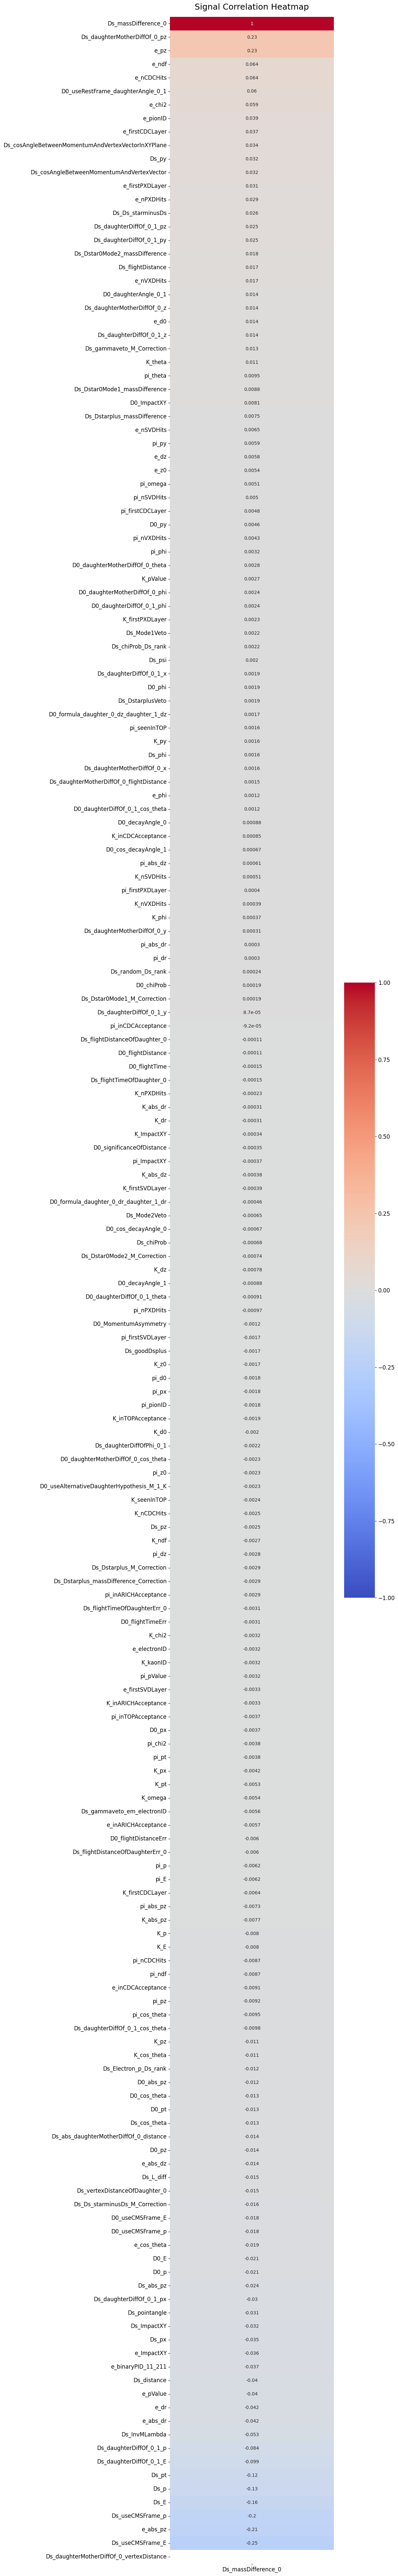

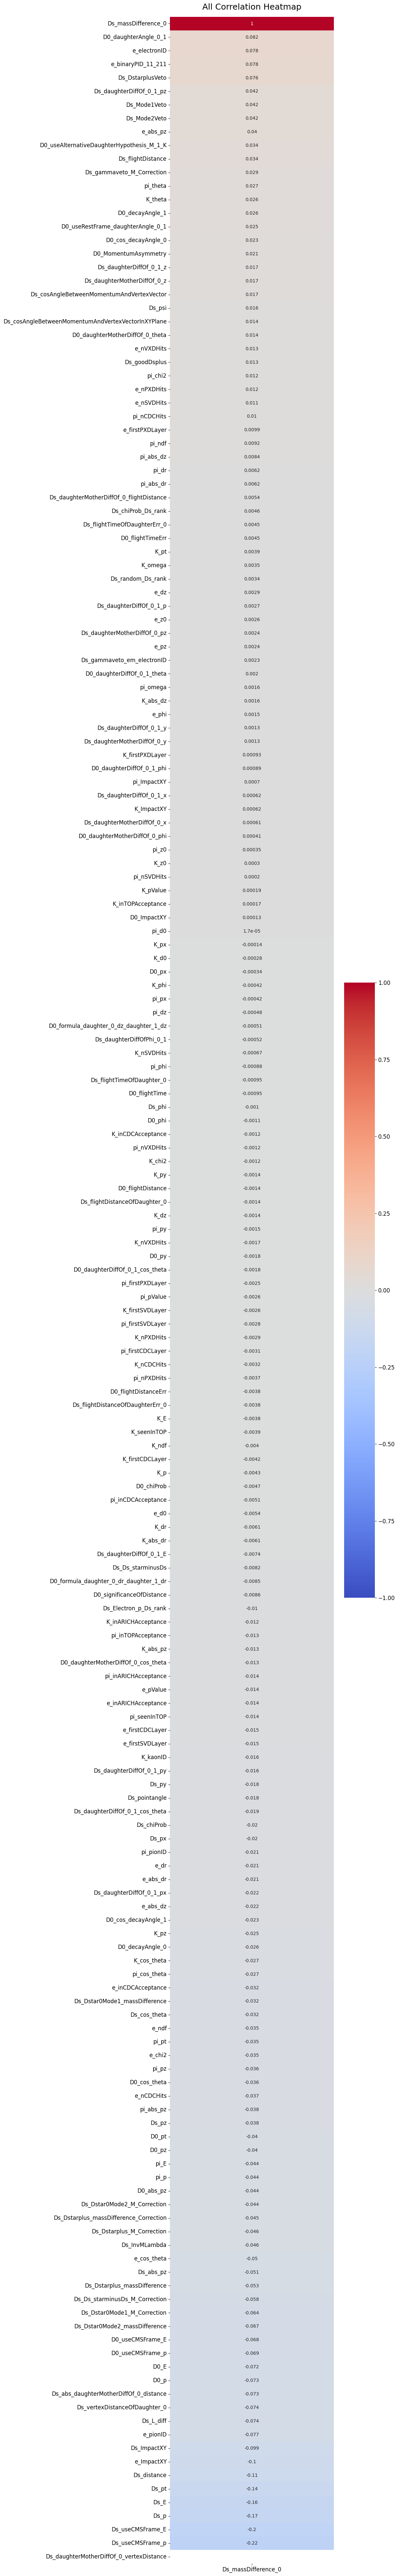

In [30]:
for key in Samples:
    plt.figure(figsize=(8, 100))

    heatmap = sns.heatmap(DataFrames[key][features].corr()[['Ds_massDifference_0']].sort_values(by='Ds_massDifference_0', ascending=False),
                          cmap="coolwarm",annot=True,vmin=-1, vmax=1)
    heatmap.set_title(key + ' Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

In [ ]:
# import matplotlib.pyplot as plt

# # === Settings ===
# Stacked = False
# Density = True
# Bins = 50
# Range = [0.0, 0.25]
# perBin = ((Range[1] - Range[0]) / Bins)
# print("Width Per Bin: {:.2f} MeV".format(perBin))

# # === Variables ===
# # plot_var = 'e_electronID'
# plot_var = 'Ds_massDifference_0'
# pdg_var = 'Ds_mcPDG'
# cut_var = "Ds_diff_D0pi"
# BS = -1

# # === Control sample: reversed PID ===
# df_ctrl = DataFrames["Signal"]
# ctrl_mask = (
#     (abs(df_ctrl["Ds_isSignal"]) == 1) &
#     (df_ctrl["e_electronID"] >= 0.9)
# )
# ctrl_dstar_plus = df_ctrl.loc[ctrl_mask, plot_var].to_numpy()

# # === Generic MC sample ===
# df_gen = DataFrames["All"]
# gen_mask = (
#     (df_gen["e_electronID"] >= 0.9) &
#     (abs(df_gen[pdg_var]) == 413)
# )
# gen_dstar_plus = df_gen.loc[gen_mask, plot_var].to_numpy()

# # === Plot ===
# plt.hist([ctrl_dstar_plus, gen_dstar_plus],
#          label=[r"$D^{*+}$", "Signal"],
#          color=["#2E2E2E", "#4C6EB1"],
#          density=Density,
#          stacked=Stacked,
#          bins=Bins,
#          range=Range,
#          histtype='step',
#          linewidth=2.5)

# plt.title(r"$D^{*+}$ Peak Comparison:" + "\n" +
#           r'$\Delta m_{\pi}(D_s^{+} - D^{0}) \notin [0.144,\; 0.147] \; \mathrm{GeV}/c^{2}$', loc="left")
# # plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
# plt.xlabel(r'$electronID \; (e)$')
# plt.ylabel(r'$Norm \; Entries/(\;{:.2f}\;)$'.format(perBin))
# plt.legend()
# # plt.ylim(0, 35)
# plt.show()